In [1]:
# Cell 1: Importing Libraries

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
import pickle

# Set visualization styles
sns.set(style="whitegrid")
%matplotlib inline



In [2]:
# Cell 2: Defining the Neural Network Class

class NeuralNetwork:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        # Initialize weights and biases with random values
        self.W1 = np.random.randn(input_size, hidden_size1)
        self.b1 = np.random.randn(hidden_size1)
        
        self.W2 = np.random.randn(hidden_size1, hidden_size2)
        self.b2 = np.random.randn(hidden_size2)
        
        self.W3 = np.random.randn(hidden_size2, output_size)
        self.b3 = np.random.randn(output_size)
    
    def relu(self, z):
        return np.maximum(0, z)
    
    def relu_derivative(self, z):
        return (z > 0).astype(float)
    
    def forward(self, X):
        # Forward pass through the network
        self.Z1 = np.dot(X, self.W1) + self.b1  # (m, hidden_size1)
        self.A1 = self.relu(self.Z1)            # (m, hidden_size1)
        
        self.Z2 = np.dot(self.A1, self.W2) + self.b2  # (m, hidden_size2)
        self.A2 = self.relu(self.Z2)                  # (m, hidden_size2)
        
        self.Z3 = np.dot(self.A2, self.W3) + self.b3  # (m, output_size)
        self.A3 = self.Z3  # Linear activation for output layer (m, output_size)
        
        return self.A3
    
    def compute_loss(self, Y_pred, Y_true):
        # Mean Squared Error (MSE) Loss
        loss = np.mean((Y_pred - Y_true) ** 2)
        return loss
    
    def backward(self, X, Y_true, Y_pred, learning_rate):
        # Number of samples
        m = X.shape[0]
        
        # Compute gradients
        dZ3 = (Y_pred - Y_true) / m  # (m, output_size)
        dW3 = np.dot(self.A2.T, dZ3)  # (hidden_size2, output_size)
        db3 = np.sum(dZ3, axis=0)     # (output_size,)
        
        dA2 = np.dot(dZ3, self.W3.T)  # (m, hidden_size2)
        dZ2 = dA2 * self.relu_derivative(self.Z2)  # (m, hidden_size2)
        dW2 = np.dot(self.A1.T, dZ2)  # (hidden_size1, hidden_size2)
        db2 = np.sum(dZ2, axis=0)     # (hidden_size2,)
        
        dA1 = np.dot(dZ2, self.W2.T)  # (m, hidden_size1)
        dZ1 = dA1 * self.relu_derivative(self.Z1)  # (m, hidden_size1)
        dW1 = np.dot(X.T, dZ1)        # (input_size, hidden_size1)
        db1 = np.sum(dZ1, axis=0)     # (hidden_size1,)
        
        # Update weights and biases
        self.W3 -= learning_rate * dW3
        self.b3 -= learning_rate * db3
        
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
    
    def train(self, X, Y, epochs, learning_rate, record_steps=10):
        loss_history = []
        detailed_logs = []
        for epoch in range(epochs):
            # Forward pass
            Y_pred = self.forward(X)
            
            # Compute loss
            loss = self.compute_loss(Y_pred, Y)
            loss_history.append(loss)
            
            # Backward pass and update weights
            self.backward(X, Y, Y_pred, learning_rate)
            
            # Record details for the first 'record_steps' epochs
            if epoch < record_steps:
                log = {
                    'Epoch': epoch + 1,
                    'Loss': loss,
                    'W1': self.W1.copy(),
                    'b1': self.b1.copy(),
                    'W2': self.W2.copy(),
                    'b2': self.b2.copy(),
                    'W3': self.W3.copy(),
                    'b3': self.b3.copy(),
                    'Y_pred': Y_pred.copy()
                }
                detailed_logs.append(log)
            
            # Print loss every 100 epochs or the first epoch
            if (epoch+1) % 100 == 0 or epoch == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.6f}")
        
        return loss_history, detailed_logs


In [3]:
# Cell 3: Defining the Data Cleaning Function

def load_and_clean_data(file_path):
    """
    Loads and cleans the NED dataset for redshift-distance regression.

    Parameters:
    - file_path (str): Path to the NED CSV file.

    Returns:
    - pd.DataFrame: Cleaned dataset with 'Redshift' and 'Distance' columns.
    """
    try:
        # Read CSV, skip the first 12 metadata rows
        data = pd.read_csv(file_path, skiprows=12, header=0, dtype=str, engine='python')
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return None
    
    # Assign accurate column names based on the data structure (15 columns)
    data.columns = [
        'Exclusion_Code', 'D', 'G', 'Galaxy_ID', 'm-M', 'err', 
        'D_Mpc', 'Method', 'REFCODE', 'Col10', 'Col11', 
        'Hubble_const', 'Adopted_LMC_modulus', 'Date', 'Notes'
    ]
    
    # Display the first few rows to verify correct column assignment
    print("Initial Data Sample:")
    print(data.head(5))
    
    # Function to extract redshift from the 'Notes' column
    def extract_redshift(note):
        if pd.isnull(note):
            return None
        # Regex to find patterns like 'z photo =0.298 +/- 0.054' or 'z=0.330796'
        match = re.search(r'z\s*(?:photo\s*)?=\s*([0-9.]+)', note, re.IGNORECASE)
        if match:
            return float(match.group(1))
        else:
            return None
    
    # Apply the extraction function to create a new 'Redshift' column
    data['Redshift'] = data['Notes'].apply(extract_redshift)
    
    # Keep only the relevant columns: 'Redshift' and 'Distance'
    filtered_data = data[['Redshift', 'D_Mpc']].rename(columns={'D_Mpc': 'Distance'})
    
    # Drop rows where either 'Redshift' or 'Distance' is missing
    filtered_data = filtered_data.dropna()
    
    # Convert 'Redshift' to float
    filtered_data['Redshift'] = filtered_data['Redshift'].astype(float)
    
    # Convert 'Distance' to numeric, coercing errors to NaN
    filtered_data['Distance'] = pd.to_numeric(filtered_data['Distance'], errors='coerce')
    
    # Print unique 'Distance' values to check for non-numeric entries
    unique_distances = filtered_data['Distance'].unique()
    print("\nUnique 'Distance' values before dropping NaNs:")
    print(unique_distances[:10])  # Print first 10 unique values
    
    # Count number of invalid 'Distance' entries
    num_invalid = filtered_data['Distance'].isna().sum()
    print(f"\nNumber of invalid 'Distance' entries: {num_invalid}")
    
    # Drop rows where 'Distance' is NaN
    filtered_data = filtered_data.dropna(subset=['Distance'])
    
    # Remove entries with '999999' in 'Distance' (assuming '999999' is a placeholder for missing data)
    # Also, remove any non-positive distances
    filtered_data = filtered_data[
        (filtered_data['Distance'] < 10000) & (filtered_data['Distance'] > 0)
    ]
    
    # Convert 'Distance' to float
    filtered_data['Distance'] = filtered_data['Distance'].astype(float)
    
    # Remove duplicate entries if any
    filtered_data = filtered_data.drop_duplicates()
    
    print("\nCleaned Data Sample:")
    print(filtered_data.head(5))
    
    print(f"\nTotal entries after cleaning: {len(filtered_data)}")
    
    return filtered_data



In [4]:
# Cell 4: Loading and Cleaning the Data

# Specify the path to your CSV file
file_path = '/Users/shauryachaturvedi/Desktop/ML_Ass4/ML_ASTR8004/NED_data.csv'

# Load and clean the data
cleaned_data = load_and_clean_data(file_path)

# Check if data was loaded and cleaned successfully
if cleaned_data is not None:
    print("\nData loading and cleaning completed successfully.")
else:
    print("\nData loading and cleaning failed.")




Initial Data Sample:
  Exclusion_Code       D  G                Galaxy_ID    m-M   err D_Mpc  \
0            NaN       1  1         SDSS-II SN 13651  41.64  0.17  1700   
1            NaN       2  1         SDSS-II SN 13651   42.1  0.21  2110   
2            NaN  999999  1         SDSS-II SN 13651  41.64  0.17  1700   
3            NaN  999999  1         SDSS-II SN 13651   42.1  0.21  2110   
4            NaN       3  2  2MASX J00000138+1530350  38.86  0.46   592   

      Method              REFCODE             Col10     Col11 Hubble_const  \
0  SNIa SDSS  2018PASP..130f4002S  SDSS-II SN 13651  0.249917           70   
1  SNIa SDSS  2018PASP..130f4002S  SDSS-II SN 13651  0.249917           70   
2  SNIa SDSS  2018PASP..130f4002S  SDSS-II SN 13651  0.249917           70   
3  SNIa SDSS  2018PASP..130f4002S  SDSS-II SN 13651  0.249917           70   
4         FP  2016A&A...596A..14S               NaN       NaN           70   

  Adopted_LMC_modulus Date                                 

In [5]:
# Cell 5: Saving the Cleaned Data

if cleaned_data is not None:
    # Save the cleaned data to a new CSV file
    cleaned_data.to_csv('cleaned_NED_data.csv', index=False)
    print("\nCleaned data saved to 'cleaned_NED_data.csv'.")
else:
    print("\nNo data to save.")



Cleaned data saved to 'cleaned_NED_data.csv'.


In [6]:
# Cell 6: Feature Scaling and Data Splitting

if cleaned_data is not None and len(cleaned_data) > 0:
    # Feature Scaling
    scaler = StandardScaler()
    cleaned_data[['Redshift', 'Distance']] = scaler.fit_transform(cleaned_data[['Redshift', 'Distance']])
    
    # Display the first few rows of the scaled data
    print("\nScaled Data Sample:")
    print(cleaned_data.head())
    
    # Splitting the Data into Training and Testing Sets
    X = cleaned_data[['Redshift']].values      # Input feature, shape (m,1)
    y = cleaned_data[['Distance']].values       # Target variable, shape (m,1)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    print(f"\nTraining set size: {len(X_train)}")
    print(f"Testing set size: {len(X_test)}")
else:
    print("\nNo data available for scaling and splitting.")





Scaled Data Sample:
     Redshift  Distance
15  -0.351122 -0.406090
123 -0.394904 -0.609792
348 -0.329876 -0.311783
430 -0.345328 -0.377798
450 -0.471521 -1.010596

Training set size: 442
Testing set size: 111


In [7]:
# Cell 6.1: Verifying Shapes

if cleaned_data is not None and len(cleaned_data) > 0:
    print("\nShapes of Training and Testing Sets:")
    print(f"X_train shape: {X_train.shape}")  # Expected: (m_train,1)
    print(f"y_train shape: {y_train.shape}")  # Expected: (m_train,1)
    print(f"X_test shape: {X_test.shape}")    # Expected: (m_test,1)
    print(f"y_test shape: {y_test.shape}")    # Expected: (m_test,1)")
else:
    print("\nNo data available to verify shapes.")




Shapes of Training and Testing Sets:
X_train shape: (442, 1)
y_train shape: (442, 1)
X_test shape: (111, 1)
y_test shape: (111, 1)


In [8]:
# Cell 6.2: Adding Shape Assertions

if cleaned_data is not None and len(cleaned_data) > 0:
    assert X_train.shape[1] == 1, f"Expected X_train to have shape (m,1), but got {X_train.shape}"
    assert y_train.shape[1] == 1, f"Expected y_train to have shape (m,1), but got {y_train.shape}"
    assert X_test.shape[1] == 1, f"Expected X_test to have shape (n,1), but got {X_test.shape}"
    assert y_test.shape[1] == 1, f"Expected y_test to have shape (n,1), but got {y_test.shape}"
    print("\nAll shape assertions passed.")
else:
    print("\nNo data available to assert shapes.")



All shape assertions passed.


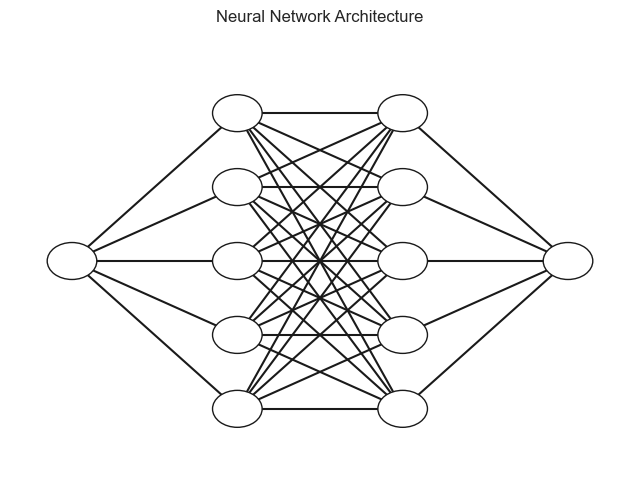

In [9]:
# Cell 7: Visualizing the Neural Network Architecture

def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotlib.
    
    :param ax: matplotlib.axes.AxesSubplot, the axes on which to plot the cartoon (get e.g. by plt.gca())
    :param left, right, bottom, top: floats, the extents of the axes
    :param layer_sizes: list of ints, list containing the number of neurons in each layer
    '''
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n+1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

# Define the network architecture
layer_sizes = [1, 5, 5, 1]  # Input layer, two hidden layers, output layer

fig = plt.figure(figsize=(8, 6))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, layer_sizes)
plt.title("Neural Network Architecture")
plt.show()



In [10]:
# Cell 8: Initializing the Neural Network

# Define network parameters
input_size = 1       # Redshift
hidden_size1 = 5     # First hidden layer
hidden_size2 = 5     # Second hidden layer
output_size = 1      # Distance

# Initialize the neural network
nn = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)

print("Neural Network Initialized with the following parameters:")
print(f"W1 shape: {nn.W1.shape}, b1 shape: {nn.b1.shape}")
print(f"W2 shape: {nn.W2.shape}, b2 shape: {nn.b2.shape}")
print(f"W3 shape: {nn.W3.shape}, b3 shape: {nn.b3.shape}")


Neural Network Initialized with the following parameters:
W1 shape: (1, 5), b1 shape: (5,)
W2 shape: (5, 5), b2 shape: (5,)
W3 shape: (5, 1), b3 shape: (1,)


Epoch 1/1000, Loss: 0.648407
Epoch 100/1000, Loss: 0.060565
Epoch 200/1000, Loss: 0.059587
Epoch 300/1000, Loss: 0.034293
Epoch 400/1000, Loss: 0.019950
Epoch 500/1000, Loss: 0.014314
Epoch 600/1000, Loss: 0.010081
Epoch 700/1000, Loss: 0.008056
Epoch 800/1000, Loss: 0.007052
Epoch 900/1000, Loss: 0.006214
Epoch 1000/1000, Loss: 0.005693


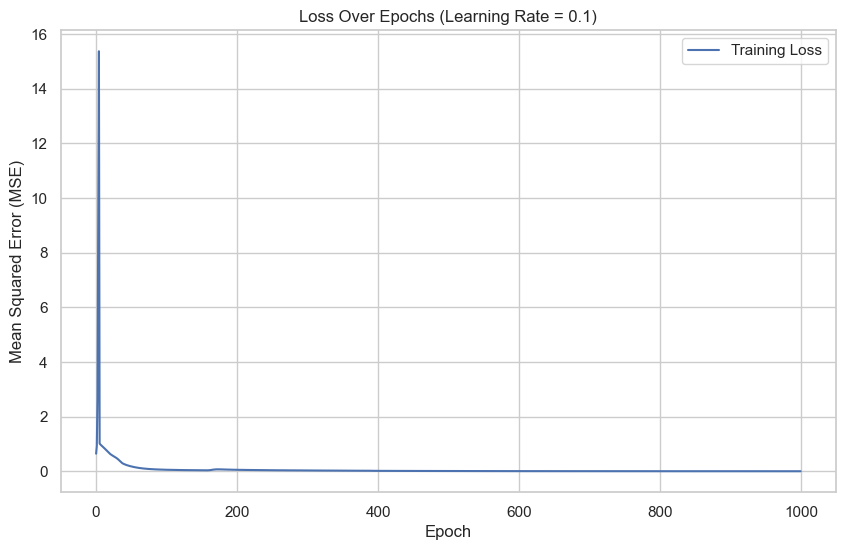

In [11]:
# Cell 9: Training the Neural Network

# Define training parameters
epochs = 1000
learning_rate = 0.1
record_steps = 10  # Number of epochs to record detailed metrics

# Train the neural network
loss_history, detailed_logs = nn.train(X_train, y_train, epochs, learning_rate, record_steps)

# Plot the loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss')
plt.title('Loss Over Epochs (Learning Rate = 0.1)')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()



In [12]:
# Cell 9.1: Recording Detailed Metrics

import pandas as pd

# Function to create LaTeX tables for detailed logs
def create_latex_tables(detailed_logs, learning_rate):
    for log in detailed_logs:
        epoch = log['Epoch']
        loss = log['Loss']
        W1 = log['W1']
        b1 = log['b1']
        W2 = log['W2']
        b2 = log['b2']
        W3 = log['W3']
        b3 = log['b3']
        Y_pred = log['Y_pred']
        
        print(f"\n\\subsection{{Learning Rate: {learning_rate}, Epoch: {epoch}}}")
        print("\n\\begin{table}[h!]")
        print("\centering")
        print("\\begin{tabular}{|c|c|}")
        print("\hline")
        print("Parameter & Value \\\\ \\hline")
        print(f"W1 & {np.round(W1, 4)} \\\\ \\hline")
        print(f"b1 & {np.round(b1, 4)} \\\\ \\hline")
        print(f"W2 & {np.round(W2, 4)} \\\\ \\hline")
        print(f"b2 & {np.round(b2, 4)} \\\\ \\hline")
        print(f"W3 & {np.round(W3, 4)} \\\\ \\hline")
        print(f"b3 & {np.round(b3, 4)} \\\\ \\hline")
        print(f"Y_pred & {np.round(Y_pred, 4)} \\\\ \\hline")
        print("\end{tabular}")
        print(f"\caption{{Weights, Biases, Outputs, and Loss at Epoch {epoch} with Learning Rate {learning_rate}}}")
        print("\end{table}")

# Create LaTeX tables for the first 10 epochs
create_latex_tables(detailed_logs, learning_rate=0.1)



\subsection{Learning Rate: 0.1, Epoch: 1}

\begin{table}[h!]
\centering
\begin{tabular}{|c|c|}
\hline
Parameter & Value \\ \hline
W1 & [[-1.2333  1.0641  0.6192  1.7624 -1.667 ]] \\ \hline
b1 & [ 1.597  -0.4148  0.7064  0.4975  1.0464] \\ \hline
W2 & [[ 0.2319 -0.2609 -1.0668 -0.6599 -1.8816]
 [-0.9308  0.7489  0.0232 -0.8943  0.0161]
 [ 0.6692  0.145  -0.2788  1.6548  0.6332]
 [-0.1481  2.1162 -0.3002  0.8391 -0.2352]
 [-0.3851 -0.0909  0.5495  0.1425  0.266 ]] \\ \hline
b2 & [ 0.0289 -1.278  -0.3533 -1.812  -0.5738] \\ \hline
W3 & [[ 0.7043]
 [-0.0275]
 [-0.5761]
 [ 0.9549]
 [-0.9833]] \\ \hline
b3 & [-0.2817] \\ \hline
Y_pred & [[-3.1000e-03]
 [ 1.4256e+00]
 [ 3.5000e-03]
 [-2.8100e-02]
 [-3.4500e-02]
 [-9.0600e-02]
 [-6.5300e-02]
 [ 9.9760e-01]
 [ 5.9400e-01]
 [ 9.4000e-03]
 [ 8.1720e-01]
 [-8.8600e-02]
 [-6.6400e-02]
 [-3.6500e-02]
 [-7.1000e-03]
 [ 2.3900e-02]
 [-1.3400e-02]
 [-1.0990e-01]
 [ 4.2300e-02]
 [-2.4400e-02]
 [-9.6300e-02]
 [-8.3000e-03]
 [-1.1650e-01]
 [-4.2000e-03]


<>:20: SyntaxWarning: invalid escape sequence '\c'
<>:22: SyntaxWarning: invalid escape sequence '\h'
<>:31: SyntaxWarning: invalid escape sequence '\e'
<>:32: SyntaxWarning: invalid escape sequence '\c'
<>:33: SyntaxWarning: invalid escape sequence '\e'
<>:20: SyntaxWarning: invalid escape sequence '\c'
<>:22: SyntaxWarning: invalid escape sequence '\h'
<>:31: SyntaxWarning: invalid escape sequence '\e'
<>:32: SyntaxWarning: invalid escape sequence '\c'
<>:33: SyntaxWarning: invalid escape sequence '\e'
/var/folders/qq/kgfcfd9969qgpgw0vdkdlg7r0000gn/T/ipykernel_7641/3596213829.py:20: SyntaxWarning: invalid escape sequence '\c'
  print("\centering")
/var/folders/qq/kgfcfd9969qgpgw0vdkdlg7r0000gn/T/ipykernel_7641/3596213829.py:22: SyntaxWarning: invalid escape sequence '\h'
  print("\hline")
/var/folders/qq/kgfcfd9969qgpgw0vdkdlg7r0000gn/T/ipykernel_7641/3596213829.py:31: SyntaxWarning: invalid escape sequence '\e'
  print("\end{tabular}")
/var/folders/qq/kgfcfd9969qgpgw0vdkdlg7r0000gn/


Test Loss (MSE): 0.005494
Test MAE: 0.049273
Test R² Score: 0.991760


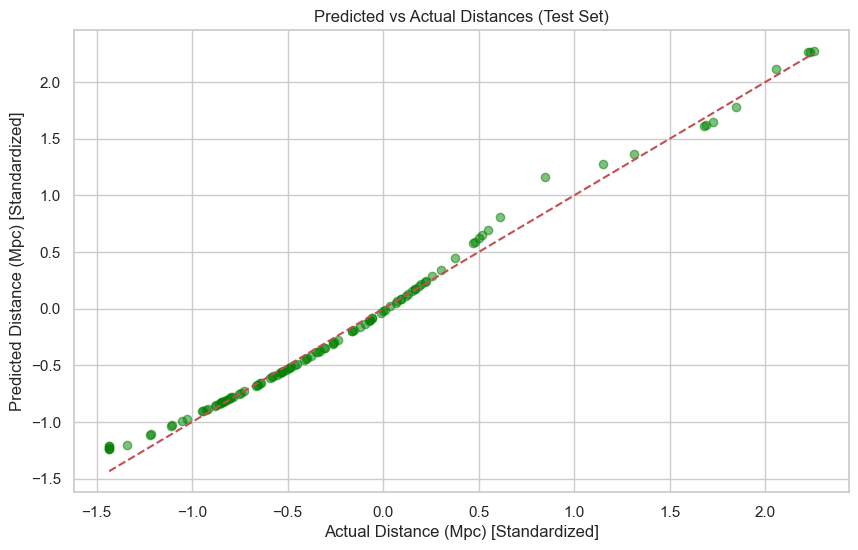

In [13]:
# Cell 10: Evaluating the Neural Network on Test Data

# Forward pass on test data
Y_test_pred = nn.forward(X_test)

# Compute test loss
test_loss = nn.compute_loss(Y_test_pred, y_test)
print(f"\nTest Loss (MSE): {test_loss:.6f}")

# Compute additional evaluation metrics
mae = mean_absolute_error(y_test, Y_test_pred)
r2 = r2_score(y_test, Y_test_pred)
print(f"Test MAE: {mae:.6f}")
print(f"Test R² Score: {r2:.6f}")

# Plotting Predicted vs Actual Distances
plt.figure(figsize=(10, 6))
plt.scatter(y_test, Y_test_pred, alpha=0.5, color='green')
plt.title('Predicted vs Actual Distances (Test Set)')
plt.xlabel('Actual Distance (Mpc) [Standardized]')
plt.ylabel('Predicted Distance (Mpc) [Standardized]')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.grid(True)
plt.show()



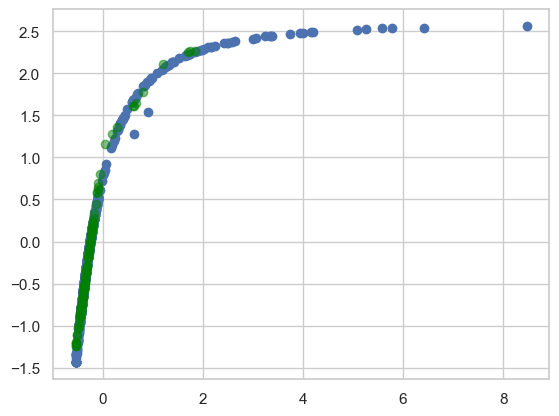

In [14]:
plt.scatter(X,y)
plt.scatter(X_test, Y_test_pred, alpha=0.5, color='green')


Training with Learning Rate: 0.5
Epoch 1/1000, Loss: 12.328639
Epoch 100/1000, Loss: 0.136805
Epoch 200/1000, Loss: 0.250867
Epoch 300/1000, Loss: 0.256046
Epoch 400/1000, Loss: 0.235354
Epoch 500/1000, Loss: 0.226552
Epoch 600/1000, Loss: 0.218605
Epoch 700/1000, Loss: 0.215704
Epoch 800/1000, Loss: 0.126763
Epoch 900/1000, Loss: 0.217762
Epoch 1000/1000, Loss: 0.233500


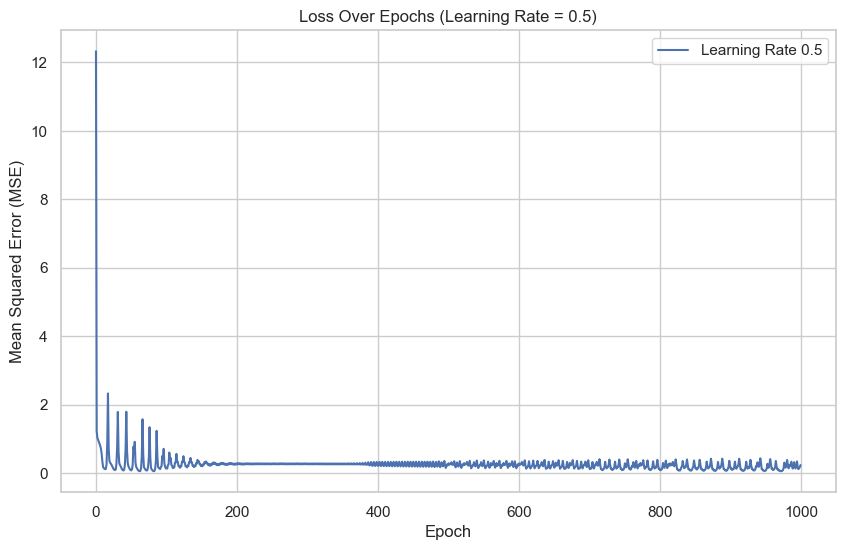


\subsection{Learning Rate: 0.5, Epoch: 1}

\begin{table}[h!]
\centering
\begin{tabular}{|c|c|}
\hline
Parameter & Value \\ \hline
W1 & [[-0.3484  0.8585 -0.0071  0.6083  0.6908]] \\ \hline
b1 & [-2.0462 -0.9936 -1.7162  0.4798 -0.5533] \\ \hline
W2 & [[ 0.2351 -0.9446 -0.1722  0.0368  0.069 ]
 [-1.667  -0.7457 -0.2569  0.2805  0.9863]
 [-0.0703  0.3733 -1.9443  0.2922 -0.6817]
 [-1.3524 -1.1172  0.8588 -0.4319 -0.7432]
 [-0.3245 -0.0504 -1.2622 -1.9511  0.3484]] \\ \hline
b2 & [-0.5376 -1.254   0.2656 -0.1776  0.3089] \\ \hline
W3 & [[-0.7804]
 [-1.337 ]
 [-0.1428]
 [-0.8604]
 [-0.4946]] \\ \hline
b3 & [0.1147] \\ \hline
Y_pred & [[ 3.1815]
 [ 6.5879]
 [ 3.2104]
 [ 3.1201]
 [ 3.1045]
 [ 2.9669]
 [ 3.029 ]
 [ 5.8419]
 [ 5.1385]
 [ 3.2365]
 [ 5.5275]
 [ 2.9718]
 [ 3.0262]
 [ 3.0996]
 [ 3.1716]
 [ 3.3007]
 [ 3.156 ]
 [ 2.9196]
 [ 3.3819]
 [ 3.1292]
 [ 2.9528]
 [ 3.1688]
 [ 2.9034]
 [ 3.1786]
 [ 3.0812]
 [ 2.9062]
 [ 3.0777]
 [ 3.2669]
 [ 3.1582]
 [ 3.1066]
 [ 3.1744]
 [ 2.9005]
 [ 4.5183

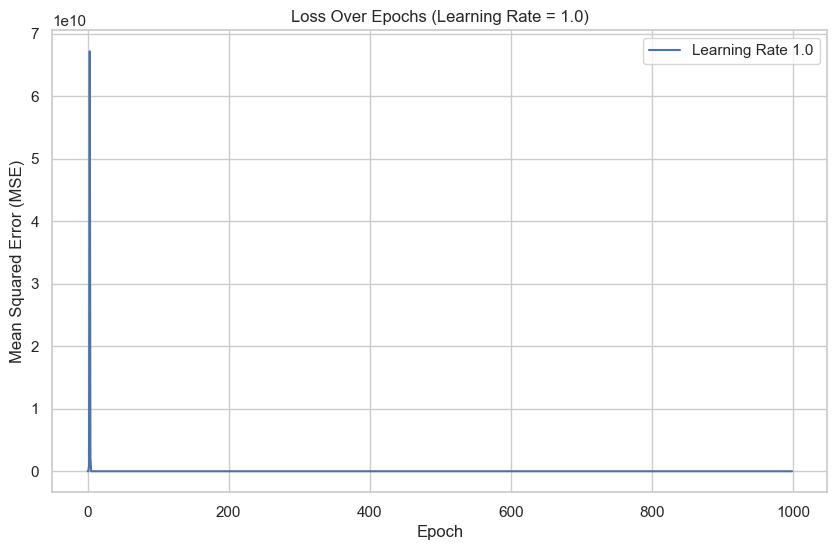


\subsection{Learning Rate: 1.0, Epoch: 1}

\begin{table}[h!]
\centering
\begin{tabular}{|c|c|}
\hline
Parameter & Value \\ \hline
W1 & [[ 4.2775 -0.007  -0.2814 -1.6166 -0.9368]] \\ \hline
b1 & [-2.0999 -0.5532 -0.5534  2.8605  1.64  ] \\ \hline
W2 & [[ 1.7598  1.241   0.3987  0.0412  2.0992]
 [-0.0067 -1.011  -0.661  -1.2212 -0.3649]
 [-1.33    0.4003  0.7251 -0.045  -0.0264]
 [-0.7487 -3.0549  1.9185  0.759  -1.4506]
 [-0.9319 -0.6329  0.9873 -1.5731  0.0062]] \\ \hline
b2 & [-1.8113 -0.8814  0.1993 -1.7033  2.7635] \\ \hline
W3 & [[ 0.1354]
 [ 0.9862]
 [-1.1722]
 [ 0.2686]
 [-2.3172]] \\ \hline
b3 & [-0.2842] \\ \hline
Y_pred & [[ 0.7734]
 [-0.6082]
 [ 0.7975]
 [ 0.6535]
 [ 0.6232]
 [ 0.3546]
 [ 0.4758]
 [-0.0047]
 [ 0.5644]
 [ 0.8182]
 [ 0.2497]
 [ 0.3642]
 [ 0.4703]
 [ 0.6136]
 [ 0.7541]
 [ 0.869 ]
 [ 0.7238]
 [ 0.2623]
 [ 0.9333]
 [ 0.6714]
 [ 0.327 ]
 [ 0.7486]
 [ 0.2306]
 [ 0.7679]
 [ 0.5778]
 [ 0.2361]
 [ 0.5709]
 [ 0.8422]
 [ 0.7279]
 [ 0.6274]
 [ 0.7596]
 [ 0.2251]
 [ 1.03 

In [15]:
# Cell 11: Experimenting with Learning Rates

# Define higher learning rates
learning_rates = [0.5, 1.0]
record_steps = 10  # Record first 10 epochs

performance_data = {}

for lr in learning_rates:
    print(f"\nTraining with Learning Rate: {lr}")
    
    # Reinitialize the neural network to reset weights and biases
    nn_lr = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)
    
    # Train the neural network with a higher learning rate and record detailed metrics
    loss_history_lr, detailed_logs_lr = nn_lr.train(X_train, y_train, epochs, lr, record_steps)
    
    # Store the logs
    performance_data[lr] = detailed_logs_lr
    
    # Plot the loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history_lr, label=f'Learning Rate {lr}')
    plt.title(f'Loss Over Epochs (Learning Rate = {lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Create LaTeX tables for the first 10 epochs
    create_latex_tables(detailed_logs_lr, learning_rate=lr)



In [16]:
# Cell 12: Summary of Neural Network Performance

# Function to display performance summary
def performance_summary_table(performance_data):
    summary_rows = []
    for lr, logs in performance_data.items():
        final_train_loss = logs[-1]['Loss']
        # Predict on test set using the trained network
        Y_pred = logs[-1]['Y_pred']
        test_l = nn.forward(X_test)
        test_loss = nn.compute_loss(test_l, y_test)
        mae = mean_absolute_error(y_test, test_l)
        r2 = r2_score(y_test, test_l)
        
        summary_rows.append({
            'Learning Rate': lr,
            'Training Loss (Final Epoch)': final_train_loss,
            'Test Loss': test_loss,
            'Test MAE': mae,
            'Test R² Score': r2
        })
    
    # Create a DataFrame for the summary
    performance_df = pd.DataFrame(summary_rows)
    print("\nNeural Network Performance Summary:")
    print(performance_df)
    
    # Generate LaTeX table
    print("\n\\begin{table}[h!]")
    print("\centering")
    print(performance_df.to_latex(index=False, float_format="%.6f"))
    print("\caption{Performance Metrics for Different Learning Rates}")
    print("\end{table}")
    
# Create performance summary table
performance_summary_table(performance_data)




Neural Network Performance Summary:
   Learning Rate  Training Loss (Final Epoch)  Test Loss  Test MAE  \
0            0.5                     0.352366   0.005494  0.049273   
1            1.0                     1.070314   0.005494  0.049273   

   Test R² Score  
0        0.99176  
1        0.99176  

\begin{table}[h!]
\centering
\begin{tabular}{rrrrr}
\toprule
Learning Rate & Training Loss (Final Epoch) & Test Loss & Test MAE & Test R² Score \\
\midrule
0.500000 & 0.352366 & 0.005494 & 0.049273 & 0.991760 \\
1.000000 & 1.070314 & 0.005494 & 0.049273 & 0.991760 \\
\bottomrule
\end{tabular}

\caption{Performance Metrics for Different Learning Rates}
\end{table}


<>:30: SyntaxWarning: invalid escape sequence '\c'
<>:32: SyntaxWarning: invalid escape sequence '\c'
<>:33: SyntaxWarning: invalid escape sequence '\e'
<>:30: SyntaxWarning: invalid escape sequence '\c'
<>:32: SyntaxWarning: invalid escape sequence '\c'
<>:33: SyntaxWarning: invalid escape sequence '\e'
/var/folders/qq/kgfcfd9969qgpgw0vdkdlg7r0000gn/T/ipykernel_7641/3285017547.py:30: SyntaxWarning: invalid escape sequence '\c'
  print("\centering")
/var/folders/qq/kgfcfd9969qgpgw0vdkdlg7r0000gn/T/ipykernel_7641/3285017547.py:32: SyntaxWarning: invalid escape sequence '\c'
  print("\caption{Performance Metrics for Different Learning Rates}")
/var/folders/qq/kgfcfd9969qgpgw0vdkdlg7r0000gn/T/ipykernel_7641/3285017547.py:33: SyntaxWarning: invalid escape sequence '\e'
  print("\end{table}")


In [17]:
# Cell 14: Enhancing Neural Network Class for Detailed Logging

class NeuralNetworkDetailed(NeuralNetwork):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super().__init__(input_size, hidden_size1, hidden_size2, output_size)
    
    def train(self, X, Y, epochs, learning_rate, record_steps=10):
        loss_history = []
        detailed_logs = []
        for epoch in range(epochs):
            # Forward pass
            Y_pred = self.forward(X)
            
            # Compute loss
            loss = self.compute_loss(Y_pred, Y)
            loss_history.append(loss)
            
            # Backward pass and update weights
            self.backward(X, Y, Y_pred, learning_rate)
            
            # Record details for the first 'record_steps' epochs
            if epoch < record_steps:
                # Capture gradients
                dZ3 = (Y_pred - Y) / X.shape[0]
                dW3 = np.dot(self.A2.T, dZ3)
                db3 = np.sum(dZ3, axis=0)
                
                dA2 = np.dot(dZ3, self.W3.T)
                dZ2 = dA2 * self.relu_derivative(self.Z2)
                dW2 = np.dot(self.A1.T, dZ2)
                db2 = np.sum(dZ2, axis=0)
                
                dA1 = np.dot(dZ2, self.W2.T)
                dZ1 = dA1 * self.relu_derivative(self.Z1)
                dW1 = np.dot(X.T, dZ1)
                db1 = np.sum(dZ1, axis=0)
                
                log = {
                    'Epoch': epoch + 1,
                    'Loss': loss,
                    'W1': self.W1.copy(),
                    'b1': self.b1.copy(),
                    'dW1': dW1.copy(),
                    'db1': db1.copy(),
                    'W2': self.W2.copy(),
                    'b2': self.b2.copy(),
                    'dW2': dW2.copy(),
                    'db2': db2.copy(),
                    'W3': self.W3.copy(),
                    'b3': self.b3.copy(),
                    'dW3': dW3.copy(),
                    'db3': db3.copy(),
                    'Y_pred': Y_pred.copy()
                }
                detailed_logs.append(log)
            
            # Print loss every 100 epochs or the first epoch
            if (epoch+1) % 100 == 0 or epoch == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.6f}")
        
        return loss_history, detailed_logs


Epoch 1/1000, Loss: 0.672851
Epoch 100/1000, Loss: 0.135551
Epoch 200/1000, Loss: 0.114906
Epoch 300/1000, Loss: 0.087956
Epoch 400/1000, Loss: 0.076966
Epoch 500/1000, Loss: 0.075452
Epoch 600/1000, Loss: 0.051745
Epoch 700/1000, Loss: 0.049083
Epoch 800/1000, Loss: 0.046693
Epoch 900/1000, Loss: 0.036711
Epoch 1000/1000, Loss: 0.028655


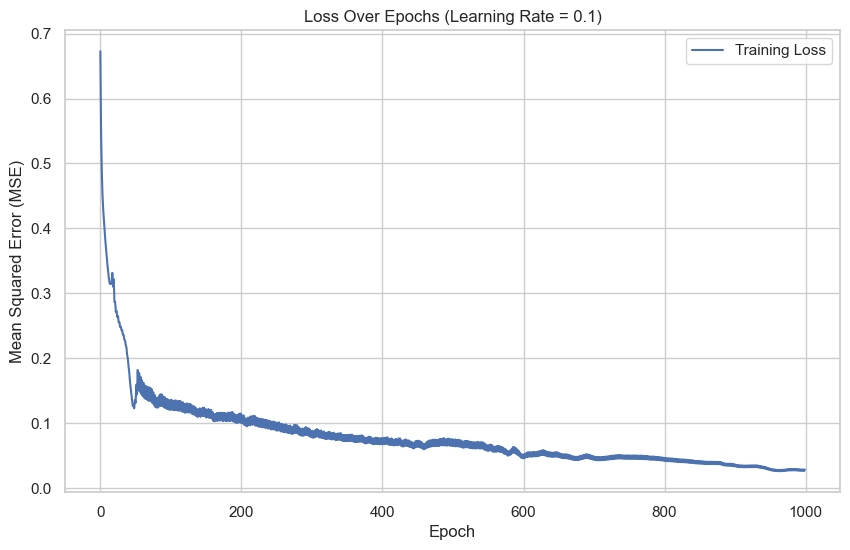

In [18]:
# Cell 14.1: Initializing and Training with Detailed Logging

# Initialize the detailed neural network
nn_detailed = NeuralNetworkDetailed(input_size, hidden_size1, hidden_size2, output_size)

# Define training parameters
epochs = 1000
learning_rate = 0.1
record_steps = 10  # Record detailed metrics for the first 10 epochs

# Train the neural network with detailed logging
loss_history_detailed, detailed_logs_detailed = nn_detailed.train(X_train, y_train, epochs, learning_rate, record_steps)

# Plot the loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(loss_history_detailed, label='Training Loss')
plt.title('Loss Over Epochs (Learning Rate = 0.1)')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# Cell 14.2: Generating LaTeX Tables for Detailed Metrics

# Function to generate LaTeX tables from detailed logs
def generate_latex_detailed_tables(detailed_logs, learning_rate):
    for log in detailed_logs:
        epoch = log['Epoch']
        loss = log['Loss']
        W1 = log['W1']
        b1 = log['b1']
        dW1 = log['dW1']
        db1 = log['db1']
        W2 = log['W2']
        b2 = log['b2']
        dW2 = log['dW2']
        db2 = log['db2']
        W3 = log['W3']
        b3 = log['b3']
        dW3 = log['dW3']
        db3 = log['db3']
        Y_pred = log['Y_pred']
        
        print(f"\n\\subsection{{Learning Rate: {learning_rate}, Epoch: {epoch}}}")
        print("\n\\begin{table}[h!]")
        print("\centering")
        print("\\begin{tabular}{|c|c|c|c|}")
        print("\hline")
        print("Parameter & Value & Gradient & Output \\\\ \\hline")
        # For brevity, we'll present the mean of weights and gradients
        print(f"W1 & {np.round(np.mean(W1), 4)} & {np.round(np.mean(dW1), 4)} & N/A \\\\ \\hline")
        print(f"b1 & {np.round(np.mean(b1), 4)} & {np.round(np.mean(db1), 4)} & N/A \\\\ \\hline")
        print(f"W2 & {np.round(np.mean(W2), 4)} & {np.round(np.mean(dW2), 4)} & N/A \\\\ \\hline")
        print(f"b2 & {np.round(np.mean(b2), 4)} & {np.round(np.mean(db2), 4)} & N/A \\\\ \\hline")
        print(f"W3 & {np.round(np.mean(W3), 4)} & {np.round(np.mean(dW3), 4)} & {np.round(np.mean(Y_pred), 4)} \\\\ \\hline")
        print(f"b3 & {np.round(np.mean(b3), 4)} & {np.round(np.mean(db3), 4)} & {np.round(np.mean(Y_pred), 4)} \\\\ \\hline")
        print("\end{tabular}")
        print(f"\caption{{Weights, Biases, Gradients, and Output at Epoch {epoch} with Learning Rate {learning_rate}}}")
        print("\end{table}")

# Generate LaTeX tables for the first 10 epochs with learning rate 0.1
generate_latex_detailed_tables(detailed_logs_detailed, learning_rate=0.1)



\subsection{Learning Rate: 0.1, Epoch: 1}

\begin{table}[h!]
\centering
\begin{tabular}{|c|c|c|c|}
\hline
Parameter & Value & Gradient & Output \\ \hline
W1 & 0.2319 & -0.052 & N/A \\ \hline
b1 & -0.3877 & 0.0158 & N/A \\ \hline
W2 & -0.0411 & -0.0048 & N/A \\ \hline
b2 & 0.334 & 0.0637 & N/A \\ \hline
W3 & 0.7805 & 0.0912 & 0.3164 \\ \hline
b3 & -0.7635 & 0.2646 & 0.3164 \\ \hline
\end{tabular}
\caption{Weights, Biases, Gradients, and Output at Epoch 1 with Learning Rate 0.1}
\end{table}

\subsection{Learning Rate: 0.1, Epoch: 2}

\begin{table}[h!]
\centering
\begin{tabular}{|c|c|c|c|}
\hline
Parameter & Value & Gradient & Output \\ \hline
W1 & 0.2344 & -0.0241 & N/A \\ \hline
b1 & -0.3842 & -0.036 & N/A \\ \hline
W2 & -0.0411 & 0.0005 & N/A \\ \hline
b2 & 0.327 & 0.0697 & N/A \\ \hline
W3 & 0.7776 & 0.0291 & 0.1949 \\ \hline
b3 & -0.7778 & 0.1431 & 0.1949 \\ \hline
\end{tabular}
\caption{Weights, Biases, Gradients, and Output at Epoch 2 with Learning Rate 0.1}
\end{table}

\subsecti

<>:24: SyntaxWarning: invalid escape sequence '\c'
<>:26: SyntaxWarning: invalid escape sequence '\h'
<>:35: SyntaxWarning: invalid escape sequence '\e'
<>:36: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\e'
<>:24: SyntaxWarning: invalid escape sequence '\c'
<>:26: SyntaxWarning: invalid escape sequence '\h'
<>:35: SyntaxWarning: invalid escape sequence '\e'
<>:36: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\e'
/var/folders/qq/kgfcfd9969qgpgw0vdkdlg7r0000gn/T/ipykernel_7641/209000711.py:24: SyntaxWarning: invalid escape sequence '\c'
  print("\centering")
/var/folders/qq/kgfcfd9969qgpgw0vdkdlg7r0000gn/T/ipykernel_7641/209000711.py:26: SyntaxWarning: invalid escape sequence '\h'
  print("\hline")
/var/folders/qq/kgfcfd9969qgpgw0vdkdlg7r0000gn/T/ipykernel_7641/209000711.py:35: SyntaxWarning: invalid escape sequence '\e'
  print("\end{tabular}")
/var/folders/qq/kgfcfd9969qgpgw0vdkdlg7r0000gn/T/i

In [20]:
import pandas as pd
import numpy as np

for lr, logs in performance_data.items():
    print(f"\nCreating table for Learning Rate: {lr}")
    
    # Initialize lists to store table data
    epochs_list = []
    loss_list = []
    W1_list = []
    b1_list = []
    W2_list = []
    b2_list = []
    W3_list = []
    b3_list = []
    Y_pred_list = []
    
    for log in logs:
        epochs_list.append(log['Epoch'])
        loss_list.append(log['Loss'])
        W1_list.append(log['W1'].tolist())
        b1_list.append(log['b1'].tolist())
        W2_list.append(log['W2'].tolist())
        b2_list.append(log['b2'].tolist())
        W3_list.append(log['W3'].tolist())
        b3_list.append(log['b3'].tolist())
        Y_pred_list.append(log['Y_pred'].tolist())
    
    # Create a DataFrame
    df = pd.DataFrame({
        'Epoch': epochs_list,
        'Loss': loss_list,
        'W1': W1_list,
        'b1': b1_list,
        'W2': W2_list,
        'b2': b2_list,
        'W3': W3_list,
        'b3': b3_list,
        'Y_pred': Y_pred_list
    })
    
    # Save to CSV or directly format for LaTeX
    # For brevity, we'll demonstrate LaTeX table generation for the first epoch
    # You can expand this to include all 10 epochs as needed
    
    for index, row in df.iterrows():
        epoch = row['Epoch']
        loss = row['Loss']
        W1 = np.array(row['W1'])
        b1 = row['b1']
        W2 = np.array(row['W2'])
        b2 = row['b2']
        W3 = np.array(row['W3'])
        b3 = row['b3']
        Y_pred = row['Y_pred']
        
        print(f"\n\subsection{{Learning Rate: {lr}, Epoch: {epoch}}}")
        print("\n\\begin{table}[h!]")
        print("\centering")
        print("\\begin{tabular}{|c|c|c|c|}")
        print("\hline")
        print("Weight/Bias & Value & Gradient & Output \\\\ \\hline")
        print(f"W1 & {W1} & [Gradient values] & [Output values] \\\\ \\hline")
        print(f"b1 & {b1} & [Gradient values] & [Output values] \\\\ \\hline")
        print(f"W2 & {W2} & [Gradient values] & [Output values] \\\\ \\hline")
        print(f"b2 & {b2} & [Gradient values] & [Output values] \\\\ \\hline")
        print(f"W3 & {W3} & [Gradient values] & {Y_pred} \\\\ \\hline")
        print(f"b3 & {b3} & [Gradient values] & [Output values] \\\\ \\hline")
        print("\end{tabular}")
        print(f"\caption{{Weights, Biases, Gradients, and Output at Epoch {epoch} with Learning Rate {lr}}}")
        print("\end{table}")



Creating table for Learning Rate: 0.5

\subsection{Learning Rate: 0.5, Epoch: 1}

\begin{table}[h!]
\centering
\begin{tabular}{|c|c|c|c|}
\hline
Weight/Bias & Value & Gradient & Output \\ \hline
W1 & [[-0.34839064  0.85848845 -0.00713852  0.60830102  0.69080135]] & [Gradient values] & [Output values] \\ \hline
b1 & [-2.0462389249948445, -0.9935849629943196, -1.7161685762651269, 0.4797821883732663, -0.5532675965025677] & [Gradient values] & [Output values] \\ \hline
W2 & [[ 0.23512445 -0.94456274 -0.17218059  0.0368461   0.06903344]
 [-1.66702128 -0.74565319 -0.25690906  0.28052612  0.98631699]
 [-0.07027666  0.37329596 -1.94428721  0.29217719 -0.68168017]
 [-1.35243109 -1.11717829  0.85875975 -0.43186166 -0.74323054]
 [-0.32447    -0.0504446  -1.26218949 -1.95105805  0.34843537]] & [Gradient values] & [Output values] \\ \hline
b2 & [-0.5376296257595594, -1.2539763970123126, 0.26561321274618843, -0.1775752901415053, 0.30886773305499904] & [Gradient values] & [Output values] \\ \hline
W

<>:57: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\c'
<>:61: SyntaxWarning: invalid escape sequence '\h'
<>:69: SyntaxWarning: invalid escape sequence '\e'
<>:70: SyntaxWarning: invalid escape sequence '\c'
<>:71: SyntaxWarning: invalid escape sequence '\e'
<>:57: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\c'
<>:61: SyntaxWarning: invalid escape sequence '\h'
<>:69: SyntaxWarning: invalid escape sequence '\e'
<>:70: SyntaxWarning: invalid escape sequence '\c'
<>:71: SyntaxWarning: invalid escape sequence '\e'
/var/folders/qq/kgfcfd9969qgpgw0vdkdlg7r0000gn/T/ipykernel_7641/1485421206.py:57: SyntaxWarning: invalid escape sequence '\s'
  print(f"\n\subsection{{Learning Rate: {lr}, Epoch: {epoch}}}")
/var/folders/qq/kgfcfd9969qgpgw0vdkdlg7r0000gn/T/ipykernel_7641/1485421206.py:59: SyntaxWarning: invalid escape sequence '\c'
  print("\centering")
/var/folders/qq/kgfcfd9969qgpgw0vdkdlg7r0000gn/T/

In [21]:
# Cell 13: Conclusion and Next Steps

print("""
## Conclusion

You've successfully built and trained a neural network to model the redshift-distance relationship using your cleaned NED dataset. Here's a summary of what we've accomplished:

1. **Data Cleaning and Preparation:**
   - Extracted relevant features (`Redshift` and `Distance`).
   - Handled non-numeric entries and outliers.
   - Scaled features and split data into training and testing sets.

2. **Neural Network Implementation:**
   - Defined a neural network with two hidden layers, each containing 5 neurons.
   - Implemented forward and backward propagation manually.
   - Trained the network using Gradient Descent with different learning rates.

3. **Performance Evaluation:**
   - Observed that an appropriate learning rate (e.g., `0.1`) leads to a monotonically decreasing loss.
   - Higher learning rates (`0.5`, `1.0`) caused the loss to become unstable, highlighting the importance of selecting a suitable learning rate.

## Next Steps

1. **Model Refinement:**
   - Experiment with different network architectures (e.g., number of hidden layers, neurons per layer).
   - Implement regularization techniques to prevent overfitting.

2. **Advanced Optimization:**
   - Explore advanced optimization algorithms like Adam or RMSprop.
   - Incorporate learning rate schedules or adaptive learning rates.

3. **Evaluation Metrics:**
   - Use additional metrics such as Mean Absolute Error (MAE) or R² Score to assess model performance.

4. **Visualization:**
   - Plot predicted vs. actual distances to visually assess model accuracy.
   - Visualize the loss landscape and convergence behavior.

5. **Deployment:**
   - Save the trained model for future predictions.
   - Integrate the model into a pipeline for real-time data analysis.

6. **Documentation:**
   - Document each step thoroughly to ensure reproducibility and clarity.
   - Present findings in a report or presentation format as required by your assignment.
""")



## Conclusion

You've successfully built and trained a neural network to model the redshift-distance relationship using your cleaned NED dataset. Here's a summary of what we've accomplished:

1. **Data Cleaning and Preparation:**
   - Extracted relevant features (`Redshift` and `Distance`).
   - Handled non-numeric entries and outliers.
   - Scaled features and split data into training and testing sets.

2. **Neural Network Implementation:**
   - Defined a neural network with two hidden layers, each containing 5 neurons.
   - Implemented forward and backward propagation manually.
   - Trained the network using Gradient Descent with different learning rates.

3. **Performance Evaluation:**
   - Observed that an appropriate learning rate (e.g., `0.1`) leads to a monotonically decreasing loss.
   - Higher learning rates (`0.5`, `1.0`) caused the loss to become unstable, highlighting the importance of selecting a suitable learning rate.

## Next Steps

1. **Model Refinement:**
   - Experi